**Introduction**

This is a very basic implementation of convolutional neural network (CNN) using pretrained model VGG-19 . Fully implemented using keras. You can learn following things by reading this.  

1. Keras implementation of a CNN using VGG-19.
3. Train only the fully connected layers after above model.
4. Train last few layers of the above model along with fully connected layers.
4. StratidiedKFold evaluation.
5. Utility funcitons required when working with images.


**Imports and Workspace setting**

In [1]:
import tensorflow as tf
import keras

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

#Variable defining
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = './plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [2]:
!ls ./plant-seedlings-classification

sample_submission.csv  test  train


**Defining categories**

In [3]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

12

**Training sample data set info**

In [4]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [5]:
def read_img(filepath, size):
    img = tf.keras.preprocessing.image.load_img(os.path.join(data_dir, filepath), target_size=size) ## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img

In [6]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(4750, 3)

In [7]:
train.head(2)

,file,category_id,category
0,train/Black-grass/0050f38b3.png,0,Black-grass
1,train/Black-grass/0183fdf68.png,0,Black-grass


**Generating vector for training samples taking equal number of images from each category**

In [8]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape

(2400, 3)

In [9]:
train

,file,category_id,category
0,train/Fat Hen/3d2f3ad0f.png,5,Fat Hen
1,train/Sugar beet/4eb03def0.png,11,Sugar beet
2,train/Black-grass/075d004bc.png,0,Black-grass
3,train/Sugar beet/1ec9ab1b8.png,11,Sugar beet
4,train/Scentless Mayweed/3bf4f0c04.png,8,Scentless Mayweed
...,...,...,...
2395,train/Shepherds Purse/85c77d977.png,9,Shepherds Purse
2396,train/Common Chickweed/14486549c.png,3,Common Chickweed
2397,train/Charlock/30a669574.png,1,Charlock
2398,train/Shepherds Purse/150ab985f.png,9,Shepherds Purse


**Understanding test-set**

In [10]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.shape

(794, 2)

In [11]:
test.head(2)

,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png


**Generating example images**

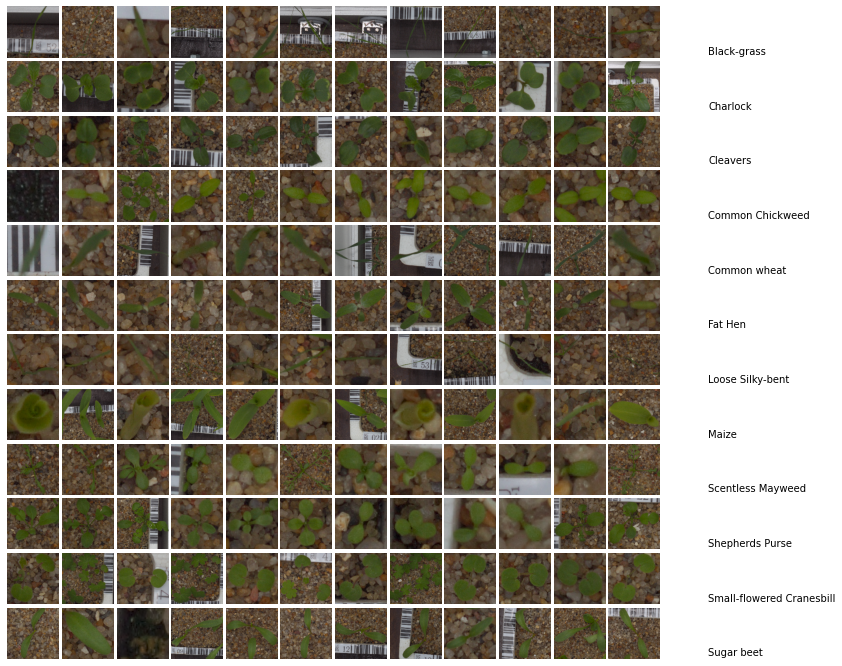

In [12]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [13]:
np.random.seed(seed=SEED)

**VGG-19 model layers identification**

In [14]:
def setTrainableLayersVGG(vgg_model):
    set_trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg_model

In [15]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = tf.keras.models.Model(vgg.input, output)

vgg_model = setTrainableLayersVGG(vgg_model)
# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

2022-06-13 04:11:03.313511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 04:11:03.340961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 04:11:03.341180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 04:11:03.341802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fb6ef03aa10>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeed0b80>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeed27a0>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fb6eeed2350>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeed2530>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeeb74f0>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fb6eeed02e0>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeeb7490>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeed3070>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fb6eeee6b00>,block3_conv3,False


**Print function for training history**

In [16]:
def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5', save_weights_only=True, monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.TensorBoard(
        log_dir='./logs', histogram_freq=1, write_graph=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=4, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
]

In [18]:
#create model from scratch
def createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs):
    print("Create Model")

    tranfer_model = 0 # just define
    
    if pretrainedModel == "VGG-19":
        tranfer_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        
        if fineTune == True:
            tranfer_model = setTrainableLayersVGG(tranfer_model)
        else:
            for layer in tranfer_model.layers:
                layer.trainable = False  # freeze feature extracting layers

    output = tranfer_model.layers[-1].output
    output = tf.keras.layers.Flatten()(output)
    trans_model = tf.keras.models.Model(tranfer_model.input, output)

    model = tf.keras.models.Sequential()
    model.add(trans_model)
    
    for i in range(0,number_of_hidden_layers):
        model.add(tf.keras.layers.Dense(512,activation = activation))
        model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(12, activation='softmax'))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate, decay=learning_rate / epochs)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate, decay=learning_rate / epochs)

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [19]:
def trainModelDF(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, cross_validation_folds, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.category_id
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")
        
        model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)

        print("======================================")
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="plant-seedlings-classification/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="plant-seedlings-classification/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH))
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit(train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1, \
                            callbacks = callbacks)
        
        scores = model.evaluate(valid_generator)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, pretrainedModel, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std

**VGG-19 as a feature extractor**

Train Model
Cross validation
Iteration =  1
Create Model
Found 1920 validated image filenames belonging to 12 classes.
Found 480 validated image filenames belonging to 12 classes.
Epoch 1/25


2022-06-13 04:11:05.980044: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


60/60 [==============================] - ETA: 0s - loss: 2.3714 - accuracy: 0.2078

2022-06-13 04:11:25.379310: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1006632960 exceeds 10% of free system memory.


60/60 [==============================] - 21s 308ms/step - loss: 2.3714 - accuracy: 0.2078 - val_loss: 1.8533 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 1.7700 - accuracy: 0.3594

2022-06-13 04:11:43.462567: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1006632960 exceeds 10% of free system memory.


60/60 [==============================] - 18s 301ms/step - loss: 1.7700 - accuracy: 0.3594 - val_loss: 1.5853 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 1.5817 - accuracy: 0.4156

2022-06-13 04:12:01.606105: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1006632960 exceeds 10% of free system memory.


60/60 [==============================] - 18s 304ms/step - loss: 1.5817 - accuracy: 0.4156 - val_loss: 1.4015 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 4/25
60/60 [==============================] - ETA: 0s - loss: 1.3684 - accuracy: 0.5021

2022-06-13 04:12:19.779578: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1006632960 exceeds 10% of free system memory.


60/60 [==============================] - 18s 305ms/step - loss: 1.3684 - accuracy: 0.5021 - val_loss: 1.3192 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 5/25
60/60 [==============================] - ETA: 0s - loss: 1.2324 - accuracy: 0.5505

2022-06-13 04:12:38.035492: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1006632960 exceeds 10% of free system memory.


60/60 [==============================] - 18s 304ms/step - loss: 1.2324 - accuracy: 0.5505 - val_loss: 1.2939 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 6/25
60/60 [==============================] - 18s 304ms/step - loss: 1.1018 - accuracy: 0.5969 - val_loss: 1.2421 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 7/25
60/60 [==============================] - 18s 303ms/step - loss: 1.0538 - accuracy: 0.6156 - val_loss: 1.2364 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 8/25
60/60 [==============================] - 18s 303ms/step - loss: 0.9794 - accuracy: 0.6552 - val_loss: 1.1608 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 9/25
60/60 [==============================] - 18s 304ms/step - loss: 0.8905 - accuracy: 0.6766 - val_loss: 1.1293 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 10/25
60/60 [==============================] - 18s 297ms/step - loss: 0.8741 - accuracy: 0.6896 - val_loss: 1.1047 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 11/25
60/60 [==============================] - 18s 304ms/step - loss

60/60 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.7995
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
15/15 [==============================] - 3s 221ms/step - loss: 0.8846 - accuracy: 0.7042
Accuarcy accuracy: 70.42%
Iteration =  3
Create Model
Found 1920 validated image filenames belonging to 12 classes.
Found 480 validated image filenames belonging to 12 classes.
Epoch 1/25
60/60 [==============================] - 19s 309ms/step - loss: 2.4318 - accuracy: 0.1833 - val_loss: 1.9068 - val_accuracy: 0.3313 - lr: 0.0010
Epoch 2/25
60/60 [==============================] - 18s 302ms/step - loss: 1.8627 - accuracy: 0.3286 - val_loss: 1.6662 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 3/25
60/60 [==============================] - 18s 298ms/step - loss: 1.5866 - accuracy: 0.4318 - val_loss: 1.3809 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 4/25
60/60 [==============================] - 18s 303ms/step - loss: 1.3566 - accuracy: 0.5094 - va

60/60 [==============================] - 18s 303ms/step - loss: 0.5753 - accuracy: 0.7953 - val_loss: 1.0620 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 20/25
60/60 [==============================] - 18s 304ms/step - loss: 0.5354 - accuracy: 0.8083 - val_loss: 1.0566 - val_accuracy: 0.6479 - lr: 1.0000e-04
Epoch 21/25
60/60 [==============================] - 18s 305ms/step - loss: 0.5480 - accuracy: 0.8115 - val_loss: 1.0723 - val_accuracy: 0.6438 - lr: 1.0000e-04
Epoch 22/25
60/60 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.8078
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
60/60 [==============================] - 18s 305ms/step - loss: 0.5464 - accuracy: 0.8078 - val_loss: 1.0557 - val_accuracy: 0.6438 - lr: 1.0000e-04
Epoch 23/25
60/60 [==============================] - 18s 304ms/step - loss: 0.5214 - accuracy: 0.8255 - val_loss: 1.0525 - val_accuracy: 0.6521 - lr: 1.0000e-05
Epoch 24/25
60/60 [===========================

(68.62500071525574, 2.2461383774607477)

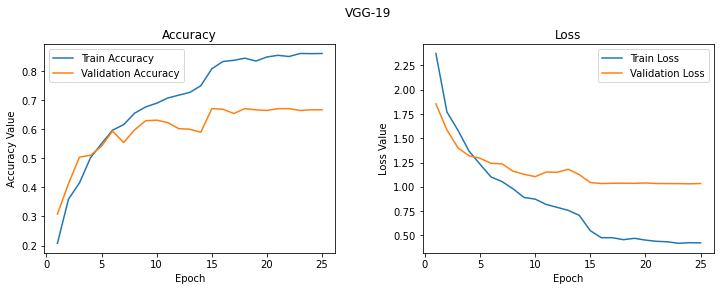

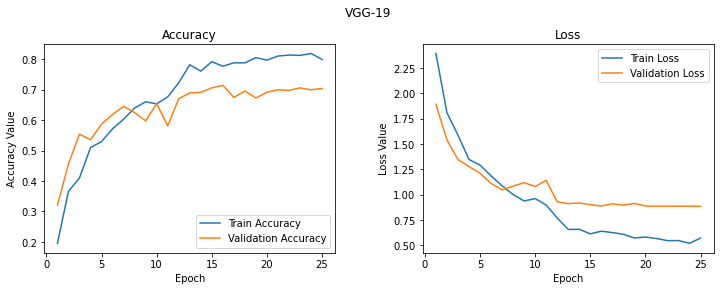

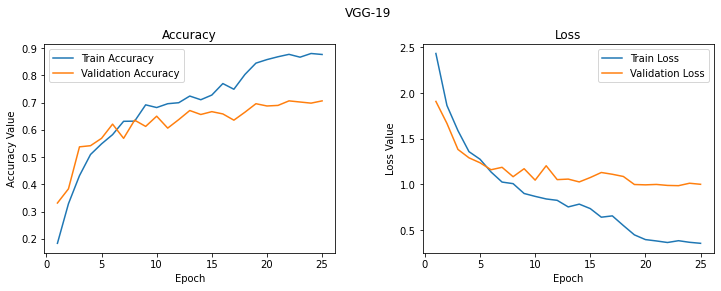

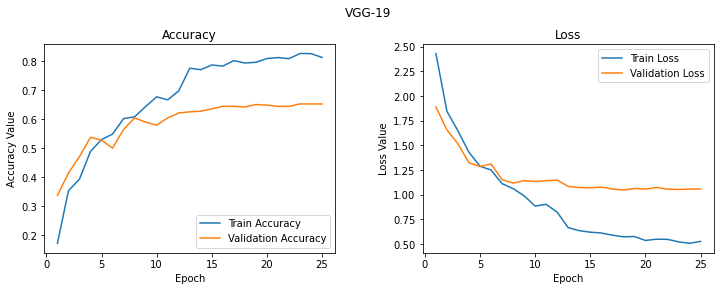

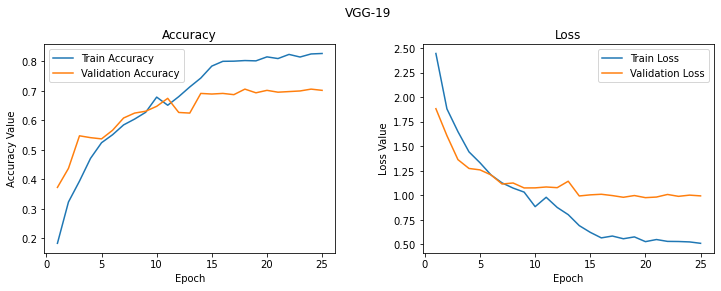

In [20]:
trainModelDF(
    train,
    pretrainedModel = "VGG-19", 
    fineTune = False,
    batch_size =32,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 25
)

**VGG-19 tuning last 2 layers as well**

In [21]:
# trainModelDF(
#     train,
#     pretrainedModel = "VGG-19", #ResNet-50
#     fineTune = True,
#     batch_size =32,
#     cross_validation_folds = 5,
#     learning_rate = 0.001,
#     activation = 'relu',
#     number_of_hidden_layers = 2,
#     optimizer = 'Adam',
#     epochs = 24
# )

In [ ]:
**Training the final model**

In [22]:
def trainFinalModel(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    print("======================================")    
    model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)
    print("======================================")
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=images,
                                                        directory="plant-seedlings-classification/",
                                                        x_col="file",
                                                        y_col="category",
                                                        batch_size=batch_size,
                                                        seed=SEED,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        target_size=(HEIGHT, WIDTH))
        
    print (train_generator.class_indices)
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    
    #Trains the model on data generated batch-by-batch by a Python generator
    model.fit(train_generator,\
            steps_per_epoch=STEP_SIZE_TRAIN, \
            epochs=epochs, \
            verbose=1, \
            callbacks = callbacks)
        
    model.save("best_model.h5")
    
    return train_generator.class_indices

In [23]:
#predict values 
def predict_createSubmission(class_indices):
    print("Predicting......")
    
    datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                        directory="plant-seedlings-classification/test/",
                                                        x_col="file",
                                                        y_col=None,
                                                        batch_size=1,
                                                        seed=SEED,
                                                        shuffle=False,
                                                        class_mode=None,
                                                        target_size=(HEIGHT, WIDTH));
        
    model = tf.keras.models.load_model('best_model.h5')
    model.summary()
    filenames = test_generator.filenames
    nb_samples = len(filenames)

    predictions = model.predict(test_generator,steps = nb_samples) # return prob of each class per image (softmax)
    
    predicted_class_indices=np.argmax(predictions,axis=1)
    
    labels = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    
    results=pd.DataFrame({"file":filenames,
                          "species":predicted_labels})

    print (results)
    
    results.to_csv("submission.csv",index=False)

    print("Prediction Completed")

In [24]:
class_indices = trainFinalModel(
    train,
    pretrainedModel = "VGG-19", 
    fineTune = False,
    batch_size = 32,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 25
)

Train Model
Create Model
Found 2400 validated image filenames belonging to 12 classes.
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
Epoch 1/25
75/75 [==============================] - 19s 241ms/step - loss: 2.3172 - accuracy: 0.2008 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - 18s 242ms/step - loss: 1.7523 - accuracy: 0.3617 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - 18s 240ms/step - loss: 1.4638 - accuracy: 0.4654 - lr: 0.0010
Epoch 4/25
75/75 [==============================] - 18s 241ms/step - loss: 1.3674 - accuracy: 0.4904 - lr: 0.0010
Epoch 5/25
75/75 [==============================] - 18s 243ms/step - loss: 1.2512 - accuracy: 0.5496 - lr: 0.0010
Epoch 6/25
75/75 [==============================] - 18s 242ms/step - loss: 1.1575 - accuracy: 0.5850 - lr:

75/75 [==============================] - 18s 243ms/step - loss: 0.6557 - accuracy: 0.7721 - lr: 0.0010
Epoch 20/25
75/75 [==============================] - 18s 242ms/step - loss: 0.6336 - accuracy: 0.7617 - lr: 0.0010
Epoch 21/25
75/75 [==============================] - 18s 241ms/step - loss: 0.5938 - accuracy: 0.7783 - lr: 0.0010
Epoch 22/25
75/75 [==============================] - 18s 240ms/step - loss: 0.6237 - accuracy: 0.7746 - lr: 0.0010
Epoch 23/25
75/75 [==============================] - 18s 242ms/step - loss: 0.5851 - accuracy: 0.7792 - lr: 0.0010
Epoch 24/25
75/75 [==============================] - 18s 242ms/step - loss: 0.5930 - accuracy: 0.7796 - lr: 0.0010
Epoch 25/25
75/75 [==============================] - 18s 243ms/step - loss: 0.5984 - accuracy: 0.7775 - lr: 0.0010


In [25]:
predict_createSubmission(class_indices)

Predicting......
Found 794 validated image filenames.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 8192)              20024384  
                                                                 
 dense_15 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 12)                6156      
                                                                 


In [26]:
import neural_structured_learning as nsl

model = tf.keras.models.load_model('models/best_model.h5')
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)

adv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [27]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.25)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                    directory="plant-seedlings-classification/",
                                                    x_col="file",
                                                    y_col="category",
                                                    batch_size=16,
                                                    seed=SEED,
                                                    shuffle=True,
                                                    subset='training',
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH))
valid_generator=datagen_train.flow_from_dataframe(dataframe=train,
                                                    directory="plant-seedlings-classification/",
                                                    x_col="file",
                                                    y_col="category",
                                                    batch_size=16,
                                                    seed=SEED,
                                                    shuffle=True,
                                                    subset='validation',
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH))


Found 1800 validated image filenames belonging to 12 classes.
Found 600 validated image filenames belonging to 12 classes.


In [42]:
def sample_from_generator(gen, nb_sample):
    cur_x, cur_y = next(gen)
    input_shape = list(cur_x.shape)[1:]
    num_classes = cur_y.shape[1]
    batch_size = len(cur_x)

    X_sample = np.zeros([nb_sample] + list(input_shape))
    Y_sample = np.zeros((nb_sample, num_classes))

    for i in range(0, nb_sample, batch_size):
        cur_x, cur_y = next(gen)
        if len(X_sample[i:i + batch_size]) < len(cur_x):
            cur_x = cur_x[:len(X_sample[i:i + batch_size])]
            cur_y = cur_y[:len(Y_sample[i:i + batch_size])]

        X_sample[i:i + batch_size] = cur_x
        Y_sample[i:i + batch_size] = cur_y
    return X_sample, Y_sample

In [43]:
train_data,train_label = sample_from_generator(train_generator,1600)
test_data,test_label = sample_from_generator(valid_generator,540)

In [45]:
print(train_data.shape,train_label.shape)
print(test_data.shape,test_label.shape)

(1600, 128, 128, 3) (1600, 12)
(540, 128, 128, 3) (540, 12)


In [49]:
adv_model.fit({'feature': train_data, 'label': train_label}, batch_size=32, epochs=25)

adv_model.evaluate({'feature': test_data, 'label': test_label})

Epoch 1/25
50/50 [==============================] - 6s 110ms/step - loss: 0.6228 - categorical_crossentropy: 0.4907 - categorical_accuracy: 0.8181 - scaled_adversarial_loss: 0.1320
Epoch 2/25
50/50 [==============================] - 6s 112ms/step - loss: 0.5822 - categorical_crossentropy: 0.4706 - categorical_accuracy: 0.8238 - scaled_adversarial_loss: 0.1117
Epoch 3/25
50/50 [==============================] - 6s 110ms/step - loss: 0.5249 - categorical_crossentropy: 0.4155 - categorical_accuracy: 0.8425 - scaled_adversarial_loss: 0.1094
Epoch 4/25
50/50 [==============================] - 6s 113ms/step - loss: 0.5242 - categorical_crossentropy: 0.4194 - categorical_accuracy: 0.8469 - scaled_adversarial_loss: 0.1047
Epoch 5/25
50/50 [==============================] - 6s 115ms/step - loss: 0.5225 - categorical_crossentropy: 0.4223 - categorical_accuracy: 0.8506 - scaled_adversarial_loss: 0.1002
Epoch 6/25
50/50 [==============================] - 6s 116ms/step - loss: 0.5101 - categorical_

[1.0120874643325806,
 0.7794497013092041,
 0.7648147940635681,
 0.23263773322105408]

In [50]:
model.save("adver_model.h5")

# Metrics

|                	|   **Accuracy**  	| **Loss** 	|
|:--------------:	|:---------------:	|:--------:	|
|                	|    **Normal**   	|          	|
| **Train Data** 	|      82.71%     	|  0.5260  	|
|  **Test Data** 	|      70.21%     	|  0.9952  	|
|                	| **Adversarial** 	|          	|
| **Train Data** 	|      86.81%     	|  0.4293  	|
|  **Test Data** 	|      76.48%     	|  1.0120  	|